In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from PIL import Image

BATCH_SIZE = 128
Z_VECTOR_SIZE = 100

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

class DatasetFromFolder(Dataset):
    def __init__(self, image_dir):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [os.path.join(image_dir, x) for x in os.listdir(image_dir) if is_image_file(x)]
        self.input_transform = transforms.Compose([
                                      transforms.Resize((64, 64)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

    def __getitem__(self, index):
        img = Image.open(self.image_filenames[index]).convert('RGBA') # automatically preprocess transparent images if there is any
        background = Image.new('RGBA', img.size, (255,255,255))       # set a white background
        alpha_composite = Image.alpha_composite(background, img).convert("RGB") # convert transparent to white by compositing
        img = self.input_transform(alpha_composite)
        return img

    def __len__(self):
        return len(self.image_filenames)

# Use this if you want to train on a custom dataset:
# dataset = DatasetFromFolder("path/to/custom/dataset")

dataset = datasets.CIFAR10('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize(64),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # changes the pixel value range to [-1, 1] (suited for tanh)
                   ]))

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

0it [00:00, ?it/s]

170500096it [00:02, 69762287.69it/s]                               


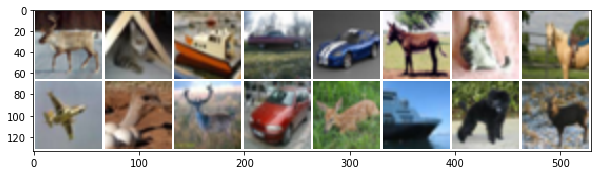

In [3]:
def show(img):
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # different dimension order PyTorch / Numpy
    
plt.rcParams["figure.figsize"] = (10,10)

show(make_grid(next(iter(train_loader))[0][:16], normalize=True, pad_value=1))

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # (100, 1, 1) -> (1024, 4, 4)
            nn.ConvTranspose2d(Z_VECTOR_SIZE, 1024, 4, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            # (1024, 4, 4) -> (512, 8, 8)
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # (512, 8, 8) -> (256, 16, 16)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # (256, 16, 16) -> (128, 32, 32)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (128, 32, 32) -> (3, 64, 64)
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.model(x)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # (3, 64, 64) -> (64, 32, 32)
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # (64, 32, 32) -> (128, 16, 16)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # (128, 16, 16) -> (256, 8, 8)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # (256, 8, 8) -> (512, 4, 4)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # (512, 4, 4) -> (1, 1, 1)
            nn.Conv2d(512, 1, 4, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        return out

In [5]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 1


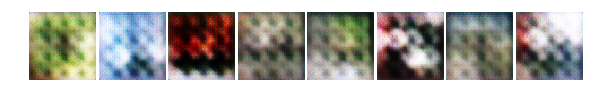

Epoch 2


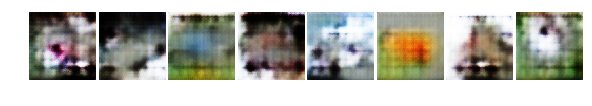

Epoch 3


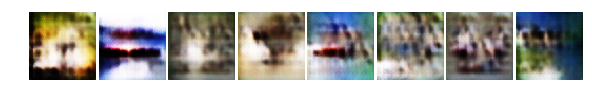

Epoch 4


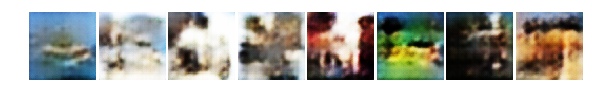

Epoch 5


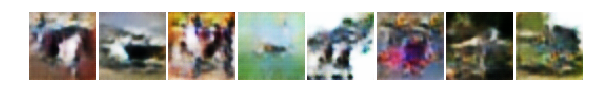

Epoch 6


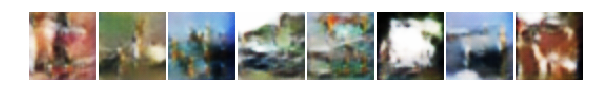

Epoch 7


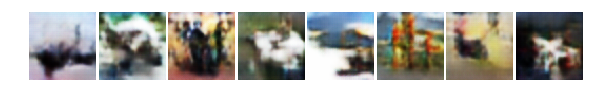

Epoch 8


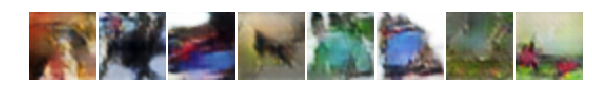

Epoch 9


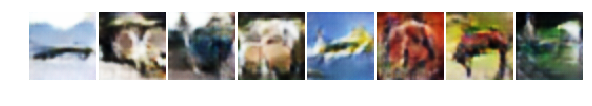

Epoch 10


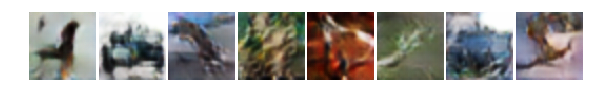

Epoch 11


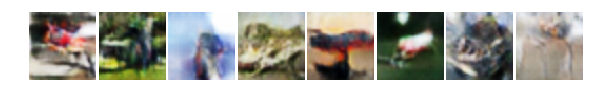

Epoch 12


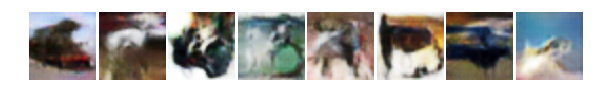

Epoch 13


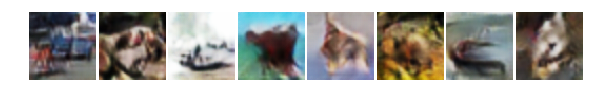

Epoch 14


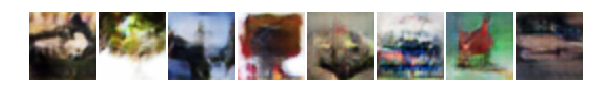

Epoch 15


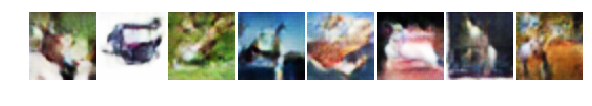

Epoch 16


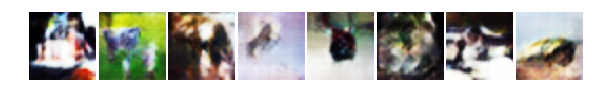

Epoch 17


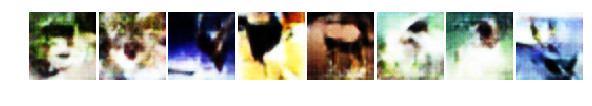

Epoch 18


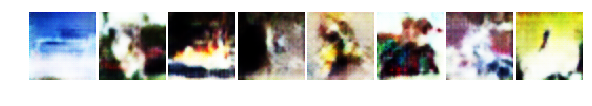

Epoch 19


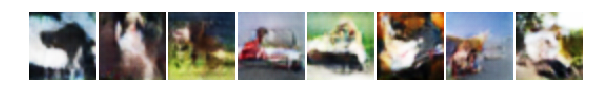

Epoch 20


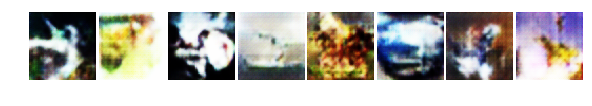

Epoch 21


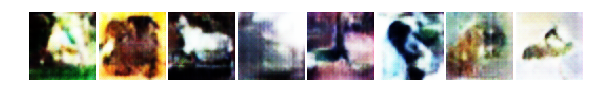

Epoch 22


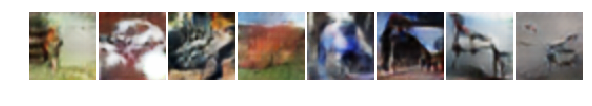

Epoch 23


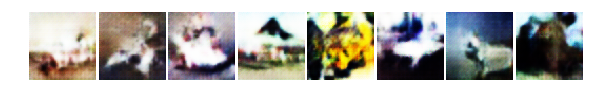

Epoch 24


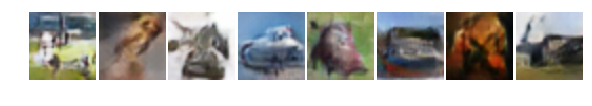

Epoch 25


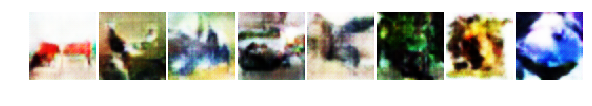

Epoch 26


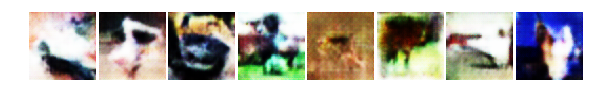

Epoch 27


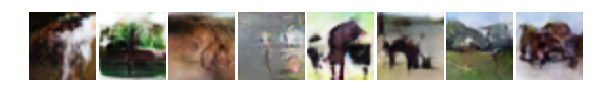

Epoch 28


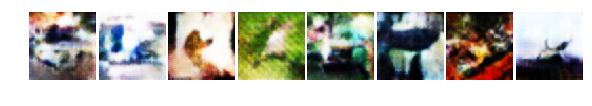

Epoch 29


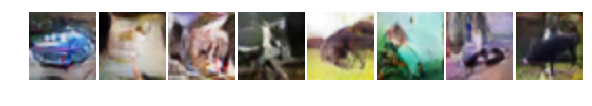

Epoch 30


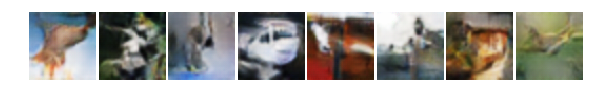

Epoch 31


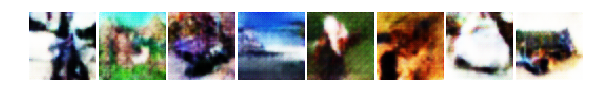

Epoch 32


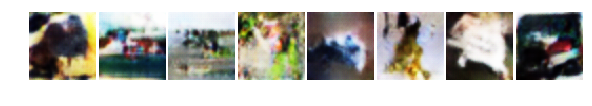

Epoch 33


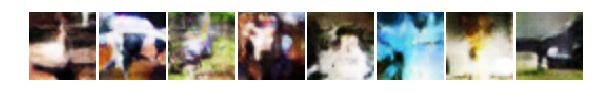

Epoch 34


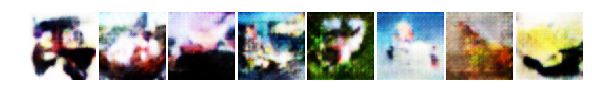

Epoch 35


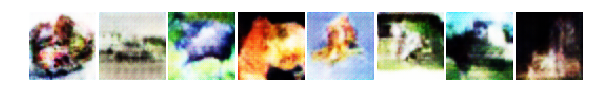

Epoch 36


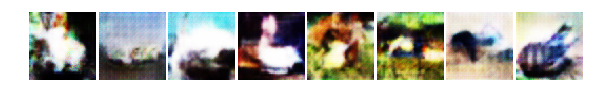

Epoch 37


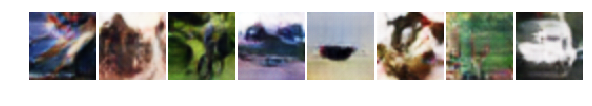

Epoch 38


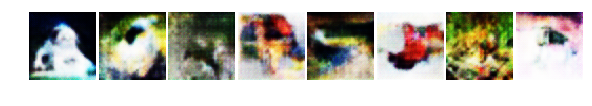

Epoch 39


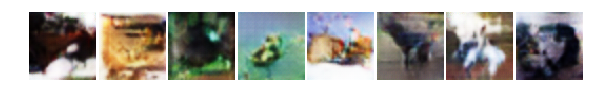

Epoch 40


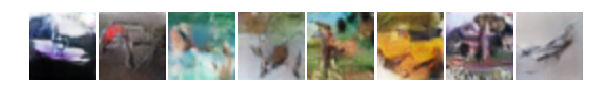

Epoch 41


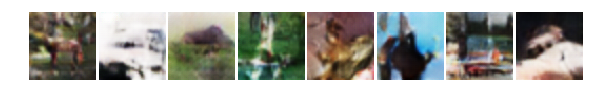

Epoch 42


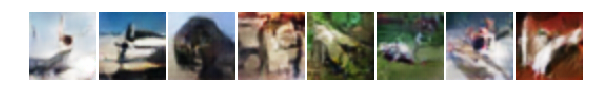

Epoch 43


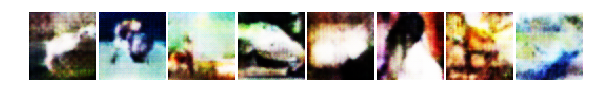

Epoch 44


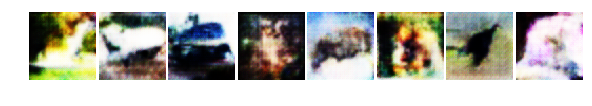

Epoch 45


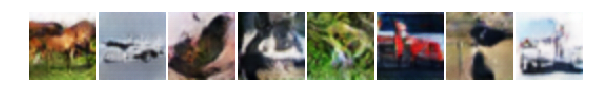

Epoch 46


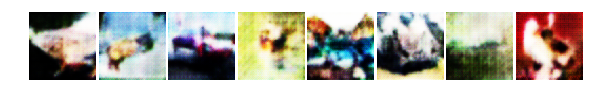

Epoch 47


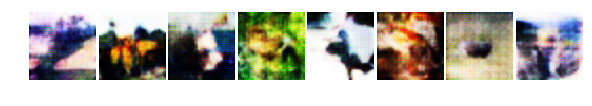

Epoch 48


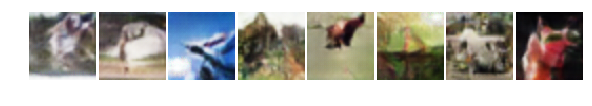

Epoch 49


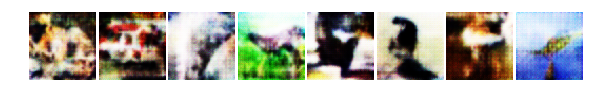

Epoch 50


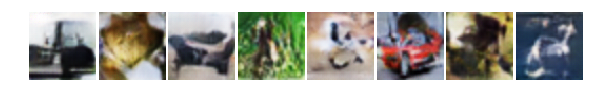

In [6]:
NB_EPOCH = 50

losses_discriminator_real = []
losses_discriminator_fake = []
losses_generator = []

real = torch.ones(BATCH_SIZE, 1).to(device)
fake = torch.zeros(BATCH_SIZE, 1).to(device)
    
for epoch in range(NB_EPOCH):
    for batch_id, (img, _) in enumerate(train_loader):

        # Train discriminator on real data
        optimizer_discriminator.zero_grad()
        real_img = img.view(img.shape[0], 3, 64, 64).to(device)
        target = real

        out = discriminator(real_img)
        loss_discriminator_real = criterion(out, target)
        loss_discriminator_real.backward()
        losses_discriminator_real.append(loss_discriminator_real)

        # Train discriminator on fake data
        z_vector = torch.randn(BATCH_SIZE, Z_VECTOR_SIZE, 1, 1).to(device)
        fake_img = generator(z_vector)
        target = fake

        out = discriminator(fake_img)
        loss_discriminator_fake = criterion(out, target)
        loss_discriminator_fake.backward()
        losses_discriminator_fake.append(loss_discriminator_fake)

        optimizer_discriminator.step()

        # Train generator
        optimizer_generator.zero_grad()
        z_vector = torch.randn(BATCH_SIZE, Z_VECTOR_SIZE, 1, 1).to(device)
        fake_img = generator(z_vector)
        target = real

        out = discriminator(fake_img)
        loss_generator = criterion(out, target)
        losses_generator.append(loss_generator)
        
        loss_generator.backward()
        optimizer_generator.step()
        
    # Show a few generated fake images
    print("Epoch", epoch+1)
    z_vector = torch.randn(8, Z_VECTOR_SIZE, 1, 1).to(device)
    fake_img = generator(z_vector)
    fake_img = fake_img.view(fake_img.shape[0], 3, 64, 64)
    show(make_grid(fake_img, normalize=True, pad_value=1))
    plt.axis("off")
    plt.show()

In [7]:
# Print the losses of the first 10 batches of each epoch
for i, (loss_d_real, loss_d_fake, loss_g) in enumerate(zip(losses_discriminator_real, 
                                                           losses_discriminator_fake, 
                                                           losses_generator)):
    if i%len(train_loader) < 10:
        print(f"D loss real: {loss_d_real:.2f} |",
              f"D loss fake: {loss_d_fake:.2f} |",
              f"G loss: {loss_g:.2f} | Epoch {i//len(train_loader)} | Batch {i%len(train_loader)+1}/{len(train_loader)}")

D loss real: 0.62 | D loss fake: 0.77 | G loss: 1.62 | Epoch 0 | Batch 1/390
D loss real: 0.56 | D loss fake: 1.42 | G loss: 1.28 | Epoch 0 | Batch 2/390
D loss real: 0.65 | D loss fake: 1.33 | G loss: 1.69 | Epoch 0 | Batch 3/390
D loss real: 0.68 | D loss fake: 1.12 | G loss: 2.12 | Epoch 0 | Batch 4/390
D loss real: 0.73 | D loss fake: 0.85 | G loss: 2.48 | Epoch 0 | Batch 5/390
D loss real: 0.73 | D loss fake: 0.84 | G loss: 2.64 | Epoch 0 | Batch 6/390
D loss real: 0.74 | D loss fake: 0.84 | G loss: 2.97 | Epoch 0 | Batch 7/390
D loss real: 0.73 | D loss fake: 0.76 | G loss: 3.26 | Epoch 0 | Batch 8/390
D loss real: 0.67 | D loss fake: 0.73 | G loss: 3.39 | Epoch 0 | Batch 9/390
D loss real: 0.76 | D loss fake: 0.52 | G loss: 3.49 | Epoch 0 | Batch 10/390
D loss real: 0.40 | D loss fake: 0.56 | G loss: 2.31 | Epoch 1 | Batch 1/390
D loss real: 0.42 | D loss fake: 0.45 | G loss: 2.38 | Epoch 1 | Batch 2/390
D loss real: 0.42 | D loss fake: 0.32 | G loss: 2.08 | Epoch 1 | Batch 3/39

D loss real: 0.27 | D loss fake: 0.36 | G loss: 1.81 | Epoch 31 | Batch 6/390
D loss real: 0.28 | D loss fake: 0.32 | G loss: 2.20 | Epoch 31 | Batch 7/390
D loss real: 0.50 | D loss fake: 0.23 | G loss: 1.95 | Epoch 31 | Batch 8/390
D loss real: 0.25 | D loss fake: 0.44 | G loss: 1.56 | Epoch 31 | Batch 9/390
D loss real: 0.25 | D loss fake: 0.27 | G loss: 1.69 | Epoch 31 | Batch 10/390
D loss real: 0.22 | D loss fake: 0.40 | G loss: 1.24 | Epoch 32 | Batch 1/390
D loss real: 0.08 | D loss fake: 0.49 | G loss: 2.04 | Epoch 32 | Batch 2/390
D loss real: 0.23 | D loss fake: 0.23 | G loss: 2.05 | Epoch 32 | Batch 3/390
D loss real: 0.28 | D loss fake: 0.22 | G loss: 1.97 | Epoch 32 | Batch 4/390
D loss real: 0.09 | D loss fake: 0.32 | G loss: 2.92 | Epoch 32 | Batch 5/390
D loss real: 0.27 | D loss fake: 0.15 | G loss: 2.28 | Epoch 32 | Batch 6/390
D loss real: 0.21 | D loss fake: 0.27 | G loss: 4.28 | Epoch 32 | Batch 7/390
D loss real: 0.09 | D loss fake: 0.13 | G loss: 3.60 | Epoch 32